# Lab 5: Principal Component Analysis (PCA) and Independent Component Analysis (ICA)

The aim of this lab is to understand and perform Principal component analysis (PCA) for a given dataset. 
PCA is a technique that is widely used for applications such as dimensionality reduction, lossy data compression, feature extraction and data visualisation.

Let's start by importing the required libraries:

In [1]:
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.decomposition import FastICA

%config InlineBackend.figure_format = 'retina'

## 1) PCA implementation

PCA consists of two main steps:
1. Find a new set of basis vectors, named the principal components, according to how much of the variance within the dataset each of these components are able to capture. The first principal component corresponds to the one which captures the most variance, the second principal component corresponds to the second most variance and so on.
2. Select the first $n$ principal components and project the original data to this new basis.

In particular, the principal components correspond to the eigenvectors of the covariance matrix of the data. The corresponding eigenvalues capture the amount of variance in that direction.

The new space is given by projecting the data onto the eigenvectors of the covariance matrix:
$$ S = XU$$
where $X$ is the $N \times D$ matrix containing the original data, $S$ is an $N \times D$ matrix representing the projected data (also called scores), and $U$ is an $D \times D$ orthonormal matrix where each of the columns represent an eigenvector of the covariance matrix.

In this section you will start by computing the eigenvalues and eigenvectors of a covariance matrix. You will project the data onto these eigenvectors to obtain points in the new space and visualise the result. 

### 1.1) Eigenvectors and eigenvalues 
Computing eigenvectors is critical for performing PCA. Given a dataset `X` and a covariance matrix ```cov_matrix```, your task is to:
1. Find the eigenvalues and eigenvector of the covariance matrix. (hint: ```np.linalg.eigh()```)
2. Sort the eigenvalues in descending order. (use the provided function ```sort_evals_descending()```)
3. Plot both the data and the new eigenvectors. (use the provided function ```plot_basis_vectors()```)

In [2]:
mean = np.array([0, 0])
orig_cov_matrix = [[1.0, 0.8], [0.8, 1.0]]
samples = 1000
X = np.random.multivariate_normal(mean, orig_cov_matrix, size=samples)
indices_for_sorting = np.argsort(X[:, 0])
X = X[indices_for_sorting, :]
cov_matrix = [[0.96595536, 0.79103839],[0.79103839, 1.00568202]]

def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. This function
    also aligns the first two eigenvectors to be in first two quadrants if
    the data is 2D (remember that any eigenvector's direction can be inverted
    and it is still an eigenvector with the same eigenvalue). 
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0], 1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1], 1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]
    return evals, evectors

def plot_basis_vectors(X, evectors):
    """
    Plots bivariate data as well as new basis vectors.
    """

    plt.figure(figsize=[4, 4])
    plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
    plt.axis('equal')
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.plot([0, evectors[0, 0]], [0, evectors[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
    plt.plot([0, evectors[0, 1]], [0, evectors[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
    plt.legend()
    plt.show()

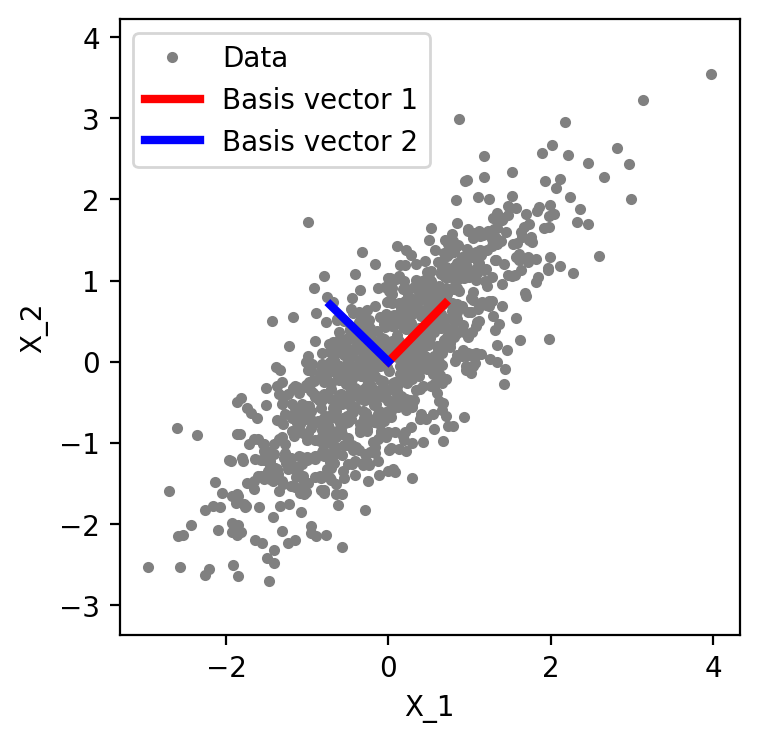

In [3]:
# Compute the eigenvalues/vectors of the covariance matrix of the data
evals, evectors = np.linalg.eigh(cov_matrix)

# Sort the eigenvalues/vectors
evals, evectors = sort_evals_descending(evals, evectors)

# Plot the basis vectors
plot_basis_vectors(X, evectors)

### 1.2) Projecting the data onto the eigenvectors
Next, create a function ```pca(X)``` to perform PCA with given data input `X`. The main steps you need to implement are:
1. Obtain the covariance matrix $S$ from `X` (where $\bar{x}$ is the mean):
$$ S = \frac{1}{N} \sum_{n=1}^N (x_n- \bar{x})(x_n- \bar{x})^T $$
2. Find the eigenvalues, eigenvectors and sort them (as you did in the previous exercise)
3. Project the initial data, `X`, onto the newly obtained eigenvectors  (hint: ```np.matmul()```)
4. The function should return 3 parameters:
    * `score`: the data projected onto the new basis
    * `evectors`: eigenvectors
    * `evals`: corresponding eigenvalues
    
Finally plot the score by utilising the provided function ```plot_data_new_basis(Y)``` where the input Y is the score.

In [62]:
def pca(X):
    # Calculate the covariance matrix of the data
    cov_matrix = np.cov(X.T)

    # Find the eigenvalues/vectors from the covariance matrix
    evals, evectors = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues/vectors
    evals, evectors = sort_evals_descending(evals, evectors)

    # Project data into principle component space
    score = np.matmul(X, evectors)

    return score, evectors, evals

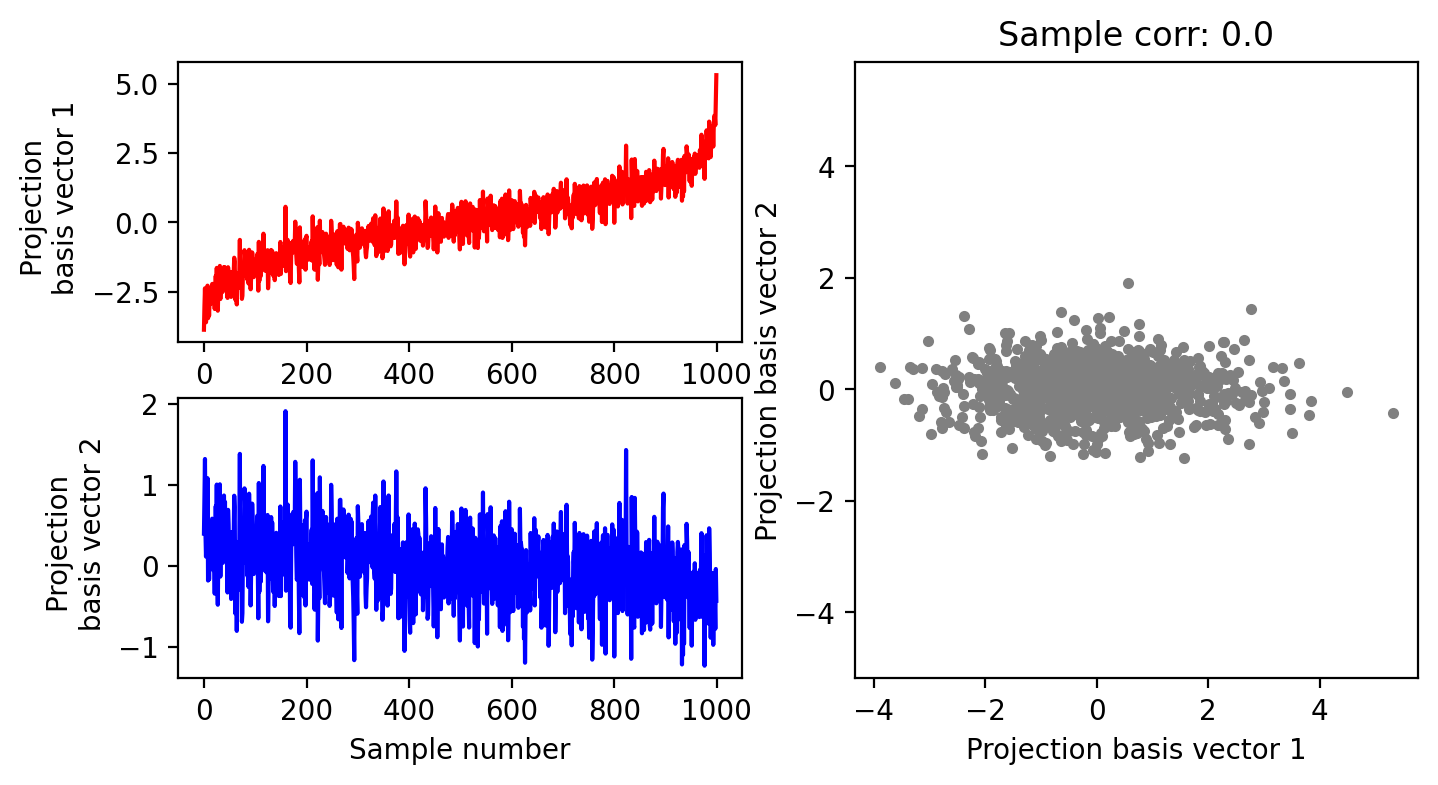

In [63]:
def plot_data_new_basis(Y):
    """
    Plots bivariate data after transformation to new bases. Similar to plot_data
    but with colors corresponding to projections onto basis 1 (red) and
    basis 2 (blue).
    The title indicates the sample correlation calculated from the data.

    Note that samples are re-sorted in ascending order for the first random
    variable.

    Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

    Returns:
    Nothing.
    """

    fig = plt.figure(figsize=[8, 4])
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(Y[:, 0], 'r')
    plt.ylabel('Projection \n basis vector 1')
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(Y[:, 1], 'b')
    plt.xlabel('Sample number')
    plt.ylabel('Projection \n basis vector 2')
    ax3 = fig.add_subplot(gs[:, 1])
    ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
    ax3.axis('equal')
    plt.xlabel('Projection basis vector 1')
    plt.ylabel('Projection basis vector 2')
    plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
    plt.show()

    
# Perform PCA on the data matrix X
score, evectors, evals = pca(X)
# Plot the data projected into the new basis
plot_data_new_basis(score)


## 2) Dimensionality reduction with PCA
A key application of PCA is dimensionality reduction, which will be the focus of the next task.

Previously we looked at a toy dataset of simple 2D data. We will now introduce the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and perform PCA on it. This dataset contains a large number of handwritten digits and is widely used to benchmark many machine learning algorithms. 

Run the following cell to load the MNIST dataset from [scikit-learn datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html#sklearn.datasets.fetch_openml) (this may take a little while) and inspect its sample output.

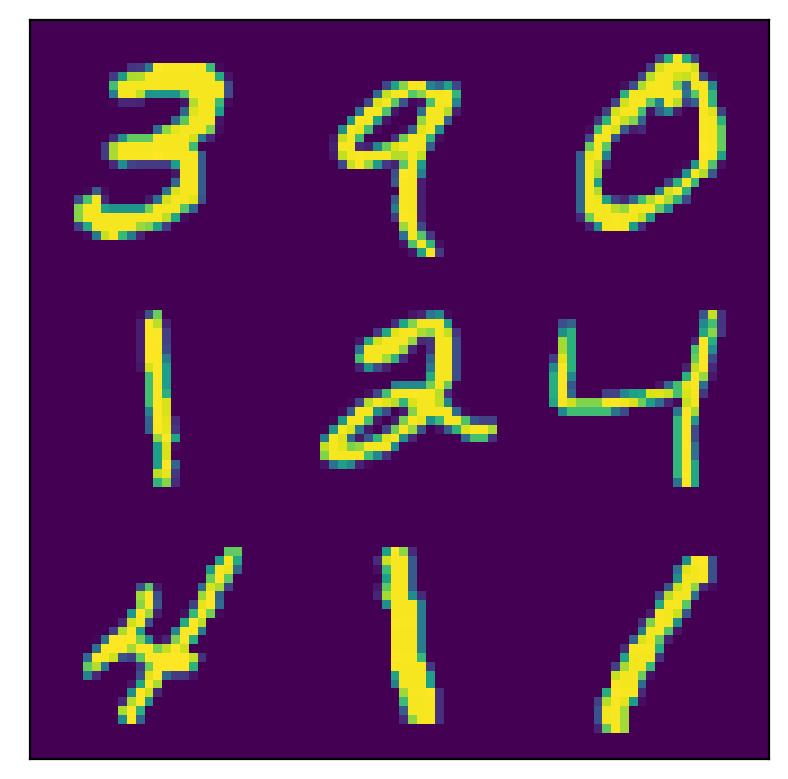

In [64]:
def plot_MNIST_sample(X):
    """
    Plots 9 images in the MNIST dataset.

    Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

    Returns:
    Nothing.

    """

    fig, ax = plt.subplots()
    k = 0
    for k1 in range(3):
        for k2 in range(3):
            k = k + 1
            plt.imshow(np.reshape(X[k, :], (28, 28)),
                     extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                     vmin=0, vmax=255)
    plt.xlim((3 * 28, 0))
    plt.ylim((3 * 28, 0))
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
    plt.clim([0, 250])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    

mnist = fetch_openml(name='mnist_784')
X = np.array(mnist.data)
plot_MNIST_sample(X)

### 2.1) Scree plot
Using the `pca(X)` function that you implemented in the exercise 1.2, calculate the eigenvalues and eigenvectors of the MNIST data `X`. Plot the eigenvalues according to their values (utilising the provided `plot_eigenvalues()` function), a graphical representation known as a scree plot.

What do you observe?

In [66]:
def plot_eigenvalues(evals, limit=True):
    """
    Plots eigenvalues.
    """

    plt.figure(figsize=(10,4))
    plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
    plt.xlabel('Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree plot')
    if limit:
        plt.xlim([0, 100])  # limit x-axis up to 100 for zooming

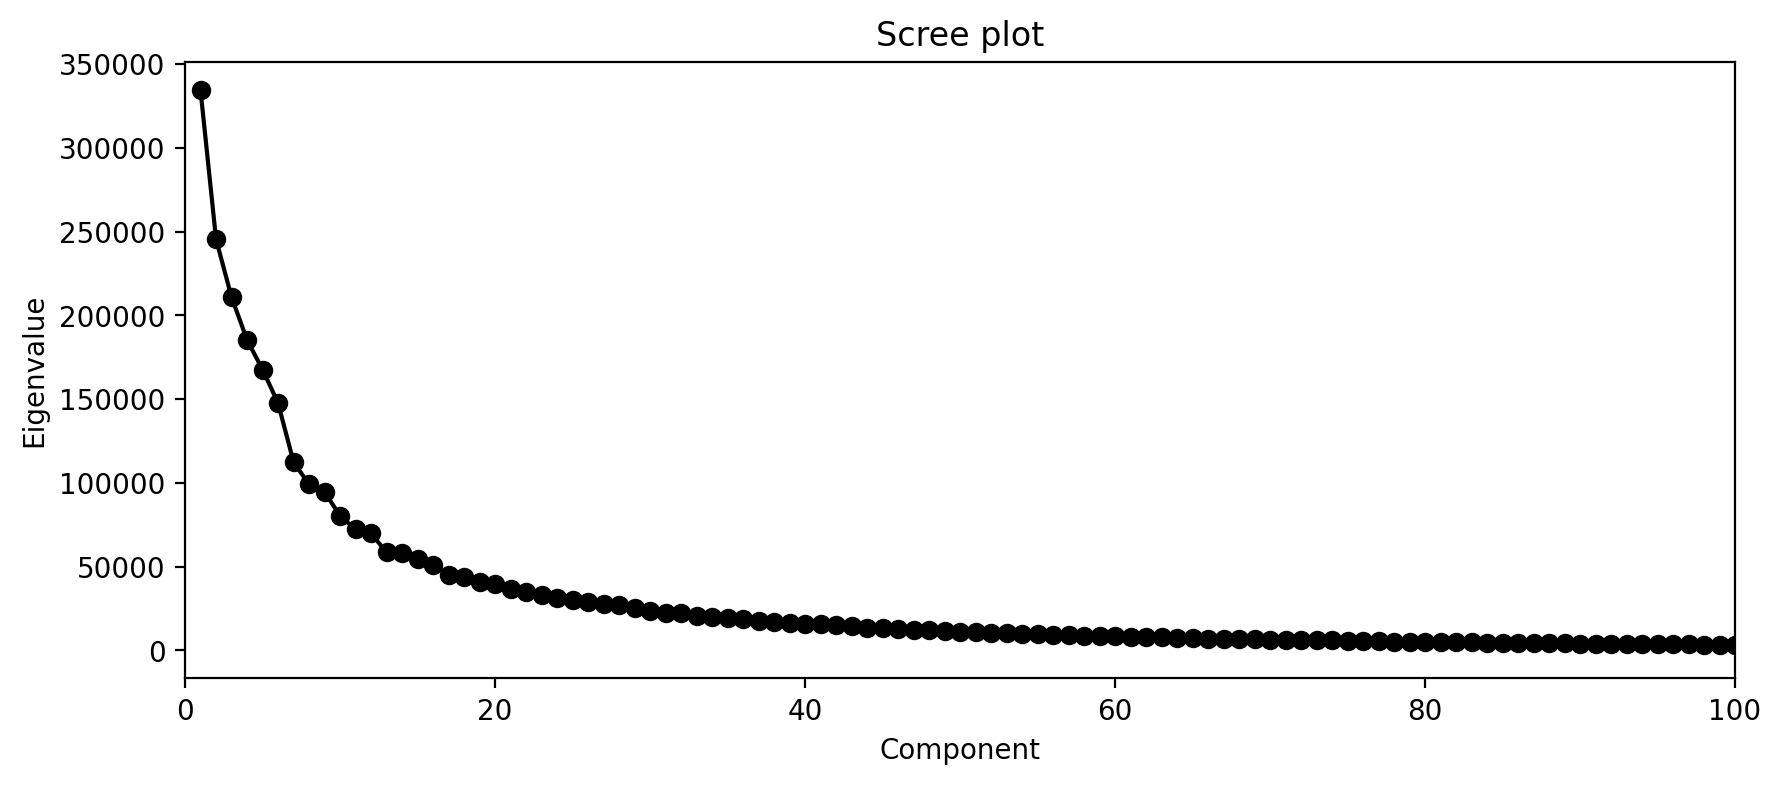

In [67]:
score, evectors, evals = pca(X)
plot_eigenvalues(evals)

### 2.2) Reconstructed data
Next, select just the first `K` components (discarding the remaining `D-K` components) and use the scores to project the data back into the orignal space of `X`.

Implement a `reconstruct_data(score, evectors, X_mean, K)` function which reconstructs the data on the first `K` components from the score and eigenvectors (hint: look at step 3. of exercise 1.2 and don't forget to add the mean). The function should return the reconstructed data, `X_reconstructed`.

In [76]:
print(np.shape(score))
print(np.shape(evectors))
print(np.shape(X))
print(np.shape(np.mean(X, axis=0)))

(70000, 784)
(784, 784)
(70000, 784)
(784,)


In [99]:
def reconstruct_data(score, evectors, X_mean, K):
    score = score[:,:K]
    evectors = np.linalg.inv(evectors)[:K]
    print(np.shape(score))
    print(np.shape(evectors))
    X_reconstructed = np.matmul(score, evectors)# + X_mean

    return X_reconstructed

Run the cell below which plots the original image and the reconstructed one. 

(70000, 100)
(100, 784)


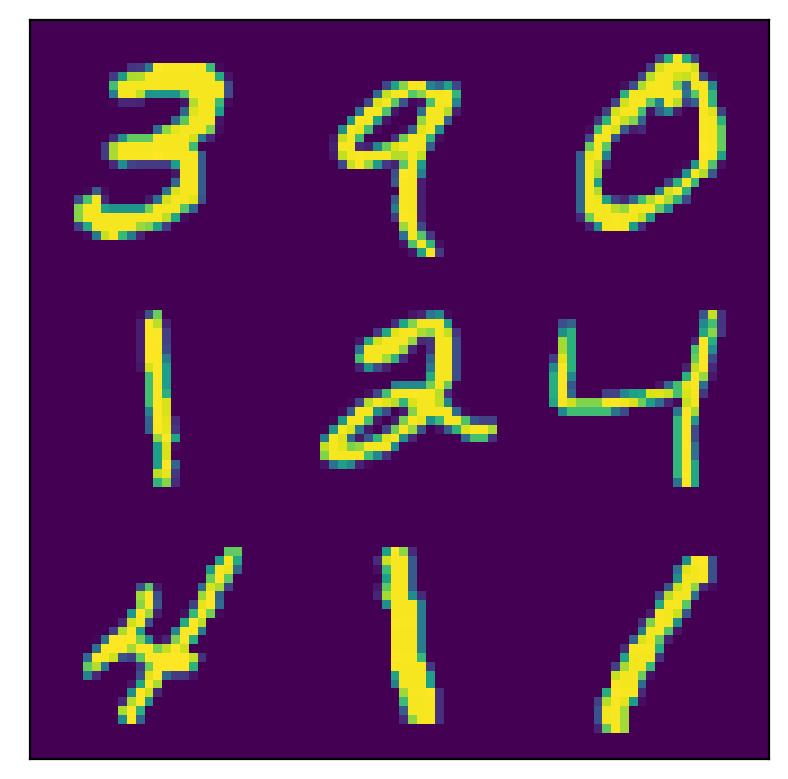

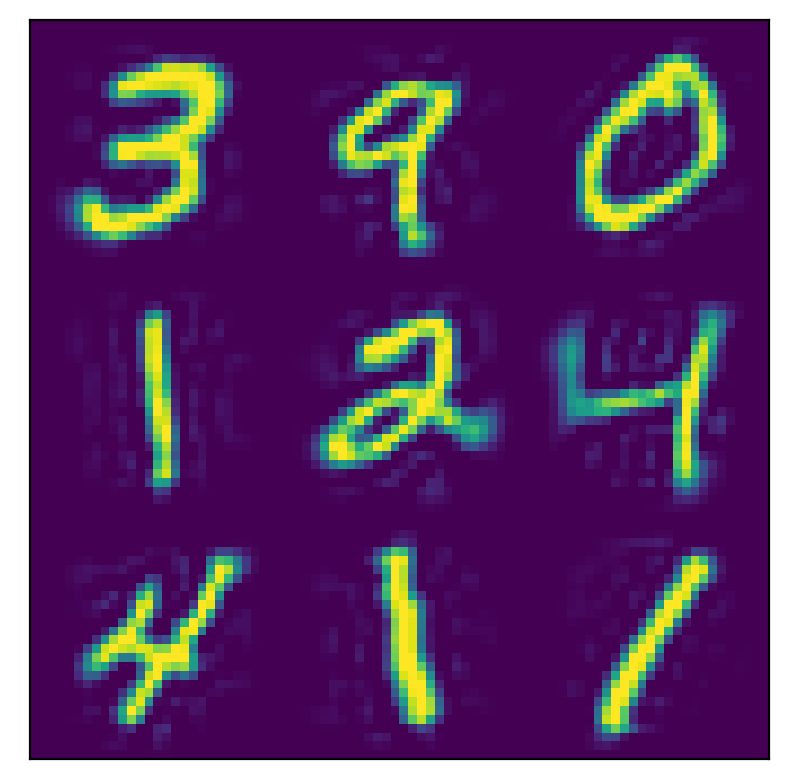

In [101]:
K = 100 # 0<K<=784 (total number of pixel values)
X_mean = np.mean(X, axis=0)
X_reconstructed = reconstruct_data(score, evectors, X_mean, K)

plot_MNIST_sample(X)
plot_MNIST_sample(X_reconstructed)

Experiment with changing the number of components, `K`. How small can you make `K` without losing too much quality? 

## 3) Kernel PCA

Instead of performing PCA on our initial data, PCA can be performed on a transformed feature space. For example, a nonlinear transformation $\phi(x)$ in an $M$-dimensional feature space will project each data point $x_n$ onto a point $\phi(x_n)$. Standard PCA can be performed in the new feature space which implicitly defines a non-linear principal component in the original data space.

The example below (from Bishop chapter 12.3) should help to illustrate this idea:

<img src="kernelPCA.png" width="400">

Reporting the excellent answer from (https://stats.stackexchange.com/questions/94463/what-are-the-advantages-of-kernel-pca-over-standard-pca): "The data points here (on the left) are located mostly along a curve in 2D. PCA cannot reduce the dimensionality from two to one, because the points are not located along a straight line. But still, the data are "obviously" located around a one-dimensional non-linear curve. ... kernel PCA can find this non-linear manifold and discover that the data are in fact nearly one-dimensional".

Your next task is to perform kernel PCA on the moon and circles dataset available from ```sklearn.datasets```.


In [122]:
datasets = {'moons': make_moons(n_samples=100, noise=0.075, random_state=300),
            'circles': make_circles(n_samples=150, noise=0.1, factor=0.2, random_state=300)}


Given the two datasets above, let's present two scatter plots and visualise each dataset distribution.

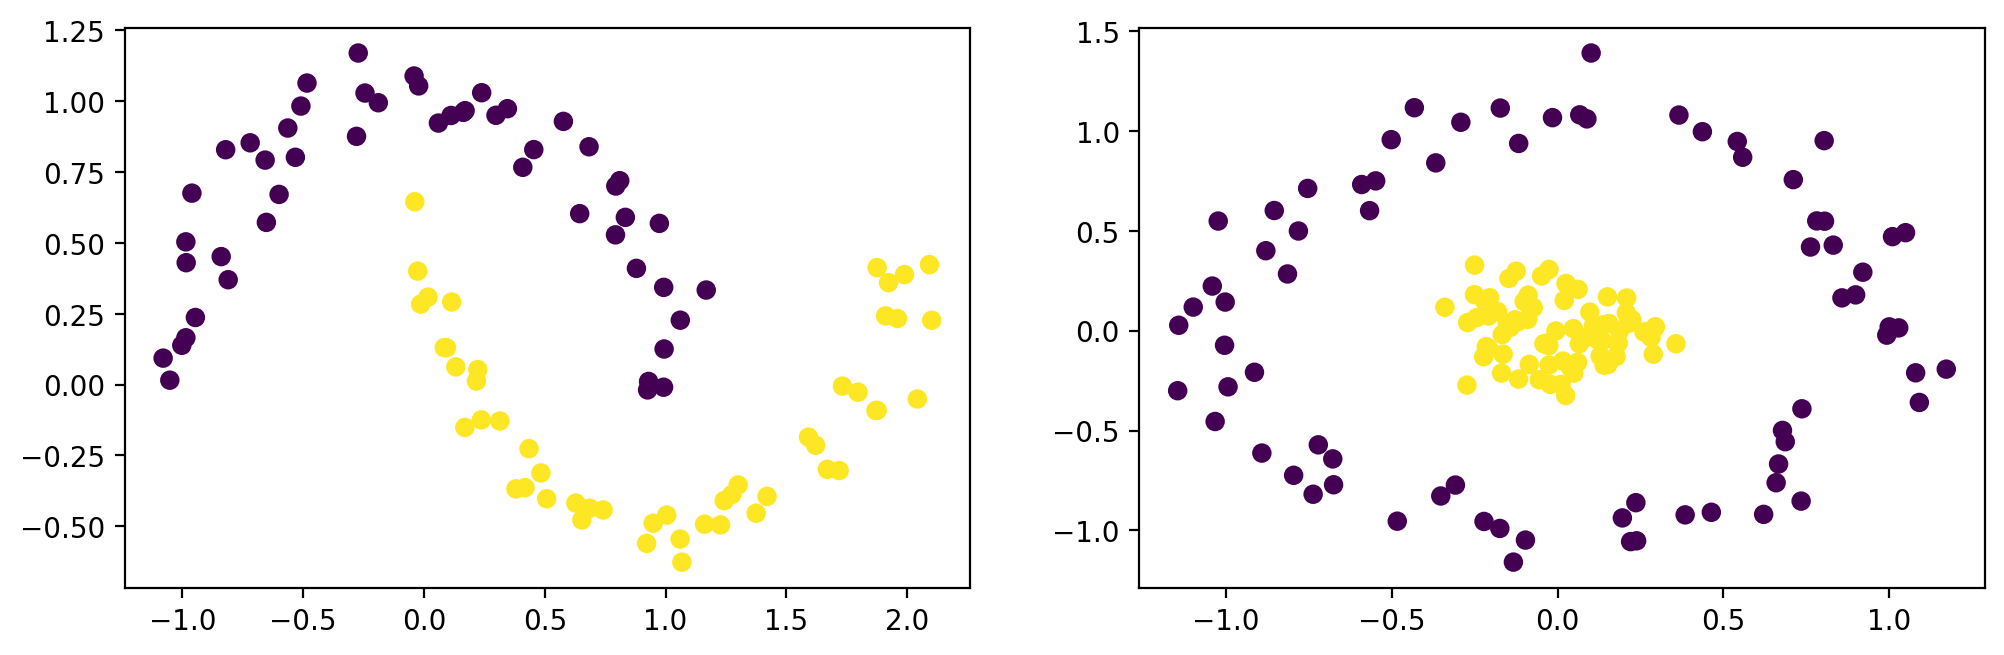

In [123]:
X_moons, y_moons = datasets['moons']
X_circles, y_circles = datasets['circles']
figure = plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_moons[:,0], X_moons[:, 1], c=y_moons)
plt.subplot(222)
plt.scatter(X_circles[:,0], X_circles[:, 1], c=y_circles)

### 3.1) Perform Kernel PCA
Write a function `kernel_PCA(dataset,gamma)` to perform KernelPCA (hint: check [KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)). Your function should take the dataset and a `gamma` value as input and return the transformed input data `X_transformed`. You should set the `n_components` parameter of `KernelPCA()` to 2 and `kernel='rbf'`. 

In [124]:
def kernel_PCA(dataset, gamma):
    X = dataset[0]
    transformer = KernelPCA(2, kernel='rbf', gamma=gamma)
    X_transformed = transformer.fit_transform(X)

    return X_transformed

In [125]:
X_moons_transformed = kernel_PCA(datasets['moons'], gamma=15)
X_circles_transformed = kernel_PCA(datasets['circles'], gamma=10)

### 3.2) Plot transformed data
Next plot the trasformed data with the corresponding labels (hint: look at how we plotted the original data)

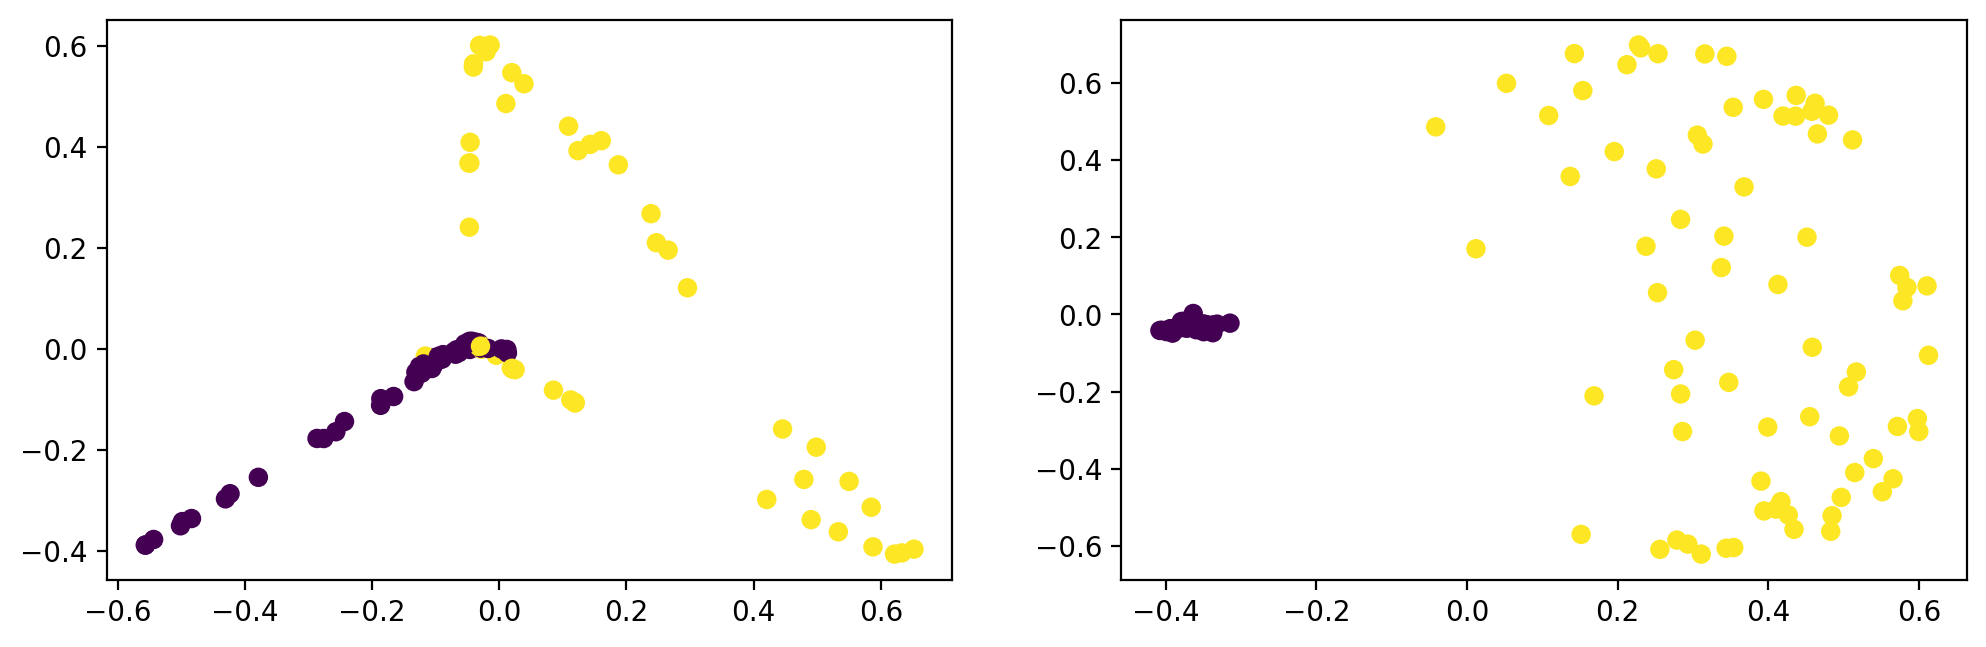

In [126]:
figure = plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_moons_transformed[:,0], X_moons_transformed[:, 1], c=y_moons)
plt.subplot(222)
plt.scatter(X_circles_transformed[:,0], X_circles_transformed[:, 1], c=y_circles)

Compared to the original data, how did the feature space change? Can you think of any tasks that could benefit from performing Kernel PCA?

As you can see for the moon dataset you cannot separate the two labels completely, go back to the cell where the dataset is created and change the noise value to 0. Re-run all the cells again and compare the plots.

## 4) ICA

Independent component analysis (ICA) is a method that allows us to separate individual components from a mixed signal. This problem is also named "blind source separation" because we are only given the mixed data and do not have access to the original sources or their mixing coefficients. Similarly to PCA, the goal of ICA is to find a linear transformation from a set of latent variables to our data. The key difference is that PCA assumes that all latents are Gaussian distributed and ICA requires that each latent is non-Gaussian (see the [lecture notes on  ICA](https://uob-coms30035.github.io/JamesLectures/ica.pdf)).

For our next exercise, we will look at three images where the content is mixed from three individual sources. The aim is to separate each source through [scikit-learn's FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html?highlight=fastica#sklearn.decomposition.FastICA) and compare to the traditional PCA algorithm.

Run the next cell to load the data and visualise the mixed data.

In [ ]:
img_1 = np.genfromtxt('mixed_img_1.dat', dtype='float64')
img_2 = np.genfromtxt('mixed_img_2.dat', dtype='float64')
img_3 = np.genfromtxt('mixed_img_3.dat', dtype='float64')

f, (ax1,ax2,ax3) = plt.subplots(1,3)
f.set_size_inches((24,40))
ax1.imshow(img_1, cmap=plt.cm.gray)
ax1.set_title("Mixed image 1")
ax2.imshow(img_2, cmap=plt.cm.gray)
ax2.set_title("Mixed image 2")
ax3.imshow(img_3, cmap=plt.cm.gray)
ax3.set_title("Mixed image 3")

### 4.1) Prepare the data
First, flatten each image and stack them together (hint: ```image.flatten()``` and ```np.vstack()```).
Check that the shape of the new data is `(3, 262144)`.

In [ ]:
# write your code here


### 4.2) Perform PCA
Initialise a PCA class with 3 components (using [scikit-learn's PCA implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) and train with the given input data obtained from the previous cell (hint: ```fit_transform()```, remember to transpose the input data ```X``` if the size is ```(3, 262144)```).
Show the images corresponding to each principal component (hint: look at the cell where the all the original mixed images are shown)

In [ ]:
# write your code here


### 4.3) Perform Fast ICA
Repeat the same process of the previous cell using [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) with 3 components.

In [ ]:
np.random.seed(2020)

In [ ]:
# write your code here


What considerations can you make while comparing FastICA to PCA? 

## Wrap-up

Congratulations, you have reached the end of this lab. Let's summarise what we learnt.
* Understand the role of eigenvectors and eigenvalues in relation to the PCA.
* Main steps behind the PCA algorithm.
* One application of the PCA with dimensionality reduction with the handwritten digits from the MNIST dataset.
* Understand the importance of Kernel PCA and FastICA.

## References 
* COMS30035 Machine Learning
* Bishop - Pattern Recognition and Machine Learning: Chapter 12 - Continuous Latent Variables 
* [Transforming nonlinear data with Kernel PCA](https://www.kaggle.com/lambdaofgod/kernel-pca-examples)
* Pablo de Castro: [SepFuentes](https://github.com/pablodecm/SepFuentes)
* [Neuromatch Academy 2020](https://www.neuromatchacademy.org)

## The End :)

<video controls src="gif.mp4" width="200">